## Style transfer

In [2]:
import torch

import numpy as np
import pandas as pd

from torchvision import models
from skimage import io, img_as_float, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import copy

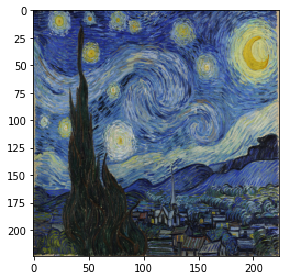

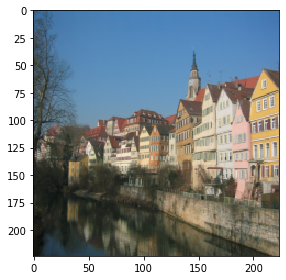

In [3]:
img_style = img_as_float(io.imread('./data/vangogh_starry_night.jpg'))
img_style = transform.resize(img_style, [224, 224])
img_content = img_as_float(io.imread('./data/Tuebingen_Neckarfront.jpg'))
img_content = transform.resize(img_content, [224, 224])

io.imshow(img_style)
io.show()
io.imshow(img_content)
io.show()

In [4]:
# VGG лучший выбор. Опционально можете попробовать с другими моделями
model = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Слои для подсчета потерь по умолчанию.
content_activation_names = ['features.32']
style_activation_names = ['features.36', 'features.26', 'features.2', 'features.9', 'features.16']

In [6]:
def img_to_tensor(img):
    image_tensor = torch.tensor(img.transpose(2, 0, 1)[None, ...]).float()
    image_tensor -= torch.tensor([0.485, 0.456, 0.406])[None, :, None, None]
    image_tensor /= torch.tensor([0.229, 0.224, 0.225])[None, :, None, None]

    return image_tensor


def post_process_image(img):
    img = img.transpose(1, 2, 0)
    img *= np.array([0.229, 0.224, 0.225])[None, None]
    img += np.array([0.485, 0.456, 0.406])[None, None]
    img = np.clip(img, 0, 1)
    return img


img_content = img_to_tensor(img_content)
img_style   = img_to_tensor(img_style)
img_input   = img_content.clone()

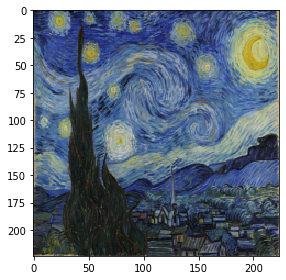

In [7]:
io.imshow(post_process_image(img_style.detach().cpu().numpy()[0]));

In [8]:
class ForwardHooks:
  def __init__(self):
      self.activation_dict = {}
        
  def get_hook(self, name):
      def hook(model, input, output):
          nonlocal self
          self.activation_dict[name] = output
      return hook


class StyleTransfer(nn.Module):
  def __init__(self, args):
    super(StyleTransfer, self).__init__()
    self.args = args
    self.content_image = args['content_image']
    self.style_image = args['style_image']
    self.output_image = nn.Parameter(args['output_image'].data)
    self.model = models.vgg16_bn(pretrained=True)
    self.optimizer = optim.Adam(
                       [self.output_image], 
                       lr = args['lr'],
                       weight_decay = args['weight_decay']
                      )
    self.content_loss_weight = args['content_loss_weight']
    self.style_loss_weight = args['style_loss_weight']
    self.loss = nn.MSELoss()

In [14]:
def gram_matrix(input):
  batch = input.size()[0]
  channels = input.size()[1]
  height = input.size()[2]
  width = input.size()[3]
  input = input.view(batch * channels, height * width)
  G = torch.mm(input, input.t())
  G = G.div(batch * channels * height * width)
  return G


def get_activations(img):
  model = models.vgg16_bn(pretrained=True)

  hooks = ForwardHooks()
  for name, module in model.named_modules():
    module.register_forward_hook(hooks.get_hook(name))

  img = model(img)
  activations = hooks.activation_dict

  return activations


def train(args, num_epochs=3):
  imgs = []
  style_transfer = StyleTransfer(args)
  
  # Объявляем хуки для получения активаций
  model = style_transfer.model
  
  # Изображения контента и стиля не меняются, а раз мы не обучаем
  # саму нейросетку, то нам достаточно один раз посчитать их активации
  content = style_transfer.content_image.clone().view(1, 3, 224, 224)
  content = get_activations(content)

  style = style_transfer.style_image.clone().view(1, 3, 224, 224)
  style = get_activations(style)

  # Говорим, что параметры нейросетки мы обучать не будем,
  # а будем обучать только само изображение
  for param in model.parameters():
    param.requires_grad = False

  # Цикл обучения
  for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    # Считаем активации искомого изображения
    output = style_transfer.output_image.clone().view(1, 3, 224, 224)
    output.data.clamp_(0, 1)
    output = get_activations(output)

    content_loss, style_loss, loss = 0, 0, 0

    # Обнуляем градиенты
    style_transfer.optimizer.zero_grad()

    # Считаем лосс
    for feature_name in content_activation_names:
      output_activations = output[feature_name]
      content_activations = content[feature_name]

      content_loss += style_transfer.loss(style_transfer.content_loss_weight * output_activations, 
                                          style_transfer.content_loss_weight * content_activations.detach())
      
    for feature_name in style_activation_names:
      output_activations = output[feature_name]
      style_activations = style[feature_name]

      gram_style = gram_matrix(style_activations)
      gram_output = gram_matrix(output_activations)

      style_loss += style_transfer.loss(style_transfer.style_loss_weight * gram_output, 
                               style_transfer.style_loss_weight * gram_style.detach())


    loss = content_loss + style_loss  
    
    print(f'Loss: {loss.item()}')

    loss.backward()
    style_transfer.optimizer.step()  
    imgs.append(style_transfer.output_image)      
     
  style_transfer.output_image.data.clamp_(0, 1)
  return imgs

In [15]:
args = pd.Series({
    'lr': 0.004,
    'weight_decay': 0.2,
    'content_loss_weight': 1,
    'style_loss_weight': 10000,
    'content_image': img_content,
    'style_image': img_style,
    'output_image': img_input,
})

imgs = train(args, num_epochs=3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0
Loss: 2.0903878211975098
Epoch: 1
Loss: 2.0787250995635986
Epoch: 2
Loss: 2.0670158863067627


In [2]:
#io.imshow(post_process_image(imgs[0].detach().cpu().numpy()[0]));